In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import rank_bm25
import nltk
from nltk import stem
import tqdm 
from toolz import partial

import rank_bm25
import pytrec_eval

plt.style.use('dark_background')

In [3]:
import httpimport
with httpimport.github_repo('lambdaofgod', 'mlutil', 
                    module='mlutil', branch='master'):
    from mlutil.parallel import mapp

In [4]:
subset = 'training'

In [5]:
!ls wikIR1k/

documents.csv  test  training  validation


In [6]:
!ls wikIR1k/test/

BM25.metrics.json  BM25.qrels.csv  BM25.res  qrels  queries.csv


## Documents

In [7]:
documents_df = pd.read_csv('wikIR1k/documents.csv', index_col='id_right')

In [8]:
documents_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99987 entries, 0 to 99999
Data columns (total 1 columns):
text_right    99987 non-null object
dtypes: object(1)
memory usage: 1.5+ MB


In [9]:
documents_df.head()

,text_right
id_right,
0,these institutions are often described as stat...
1,parents usually notice signs during the first ...
2,a planet like earth it is dimensionless and me...
3,it is similar to the ancient greek letter alph...
4,it is bordered by tennessee to the north georg...


In [10]:
document_lengths = documents_df['text_right'].apply(lambda s: s.count(' '))

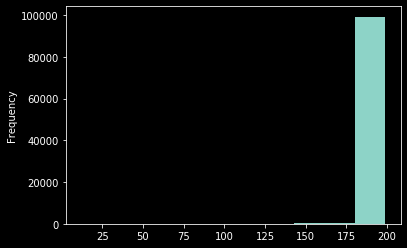

In [11]:
document_lengths.plot.hist();

## Queries

In [12]:
queries_df = pd.read_csv('wikIR1k/{}/queries.csv'.format(subset), index_col='id_left')

In [13]:
queries_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1645 entries, 17783 to 12052
Data columns (total 1 columns):
text_left    1645 non-null object
dtypes: object(1)
memory usage: 25.7+ KB


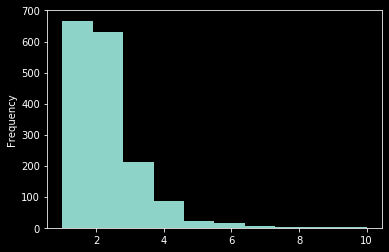

In [14]:
queries_df['text_left'].apply(lambda s: len(s.split())).plot.hist();

# BM25 results

In [15]:
!head wikIR1k/training/BM25.qrels.csv

,id_left,id_right,label
0,17783,77063,0
1,17783,17774,0
2,17783,17783,2
3,17783,20576,0
4,17783,77066,0
5,17783,35888,1
6,17783,77064,0
7,17783,97038,1
8,17783,29547,0


In [16]:
relevances = pd.read_csv('wikIR1k/{}/BM25.qrels.csv'.format(subset))
relevant_pairs=relevances[relevances['label'] != 0]
relevant_pairs.shape

(8588, 4)

In [17]:
relevant_pairs.merge(queries_df, on='id_left').merge(documents_df, on='id_right')

,Unnamed: 0,id_left,id_right,label,text_left,text_right
0,2,17783,17783,2,apulia,the region comprises and its population is abo...
1,5,17783,35888,1,apulia,it also has two coastlines a 30 km stretch on ...
2,21902,17774,35888,1,calabria,it also has two coastlines a 30 km stretch on ...
3,37971,95944,35888,1,regions of italy,it also has two coastlines a 30 km stretch on ...
4,74818,17843,35888,1,campania,it also has two coastlines a 30 km stretch on ...
...,...,...,...,...,...,...
8583,164400,12052,29167,1,sonic youth,after graduating from los angeles s otis colle...
8584,164401,12052,88503,1,sonic youth,the band recorded the album between july and a...
8585,164403,12052,12052,2,sonic youth,founding members thurston moore guitar vocals ...
8586,164404,12052,29166,1,sonic youth,he has also participated in many solo and grou...


In [18]:
stop_words = set(nltk.corpus.stopwords.words('english'))


def get_document_stems(doc_with_key, stemmer):
    key, value = doc_with_key
    value = value['text_right']
    stems = [stemmer.stem(elem) for elem in value.split(" ") if elem not in stop_words]
    return key, value.split() 


def make_bm25(documents, stemmer=stem.PorterStemmer(), bm25_class=rank_bm25.BM25Okapi):
    docs_dict = dict(mapp(partial(get_document_stems, stemmer=stemmer), documents.iterrows()))
    return bm25_class(docs_dict.values())

In [19]:
def make_relevance_dict(queries_df, relevant_indices):
    return {
        str(l): {
            str(k): v
            for (k, v) in relevant_indices[i].to_dict().items()
        }
        for i, l in enumerate(queries_df.index)
    }


def get_predicted_relevant_indices(queries_df, bm25, k=100):
    bm25_relevant_indices = []
    for __, q in tqdm.tqdm(queries_df.iterrows(), total=len(queries_df)):
        query = [nltk.stem.PorterStemmer().stem(t) for t in q['text_left'].split()]
        scores = bm25.get_scores(query)
        sorted_indices = np.argsort(scores)[::-1][:k]
        sorted_scores = scores[sorted_indices]
        document_indices = documents_df.index[sorted_indices]
        bm25_relevant_indices.append(pd.Series(sorted_scores, index=document_indices))
    
    return bm25_relevant_indices


def setup_evaluator_from_relevance_file(qrel_path, measures={"map","ndcg_cut","recall","P"}):
    with open(qrel_path, 'r') as f_qrel:
        qrel = pytrec_eval.parse_qrel(f_qrel)

    return pytrec_eval.RelevanceEvaluator(qrel,measures)


def get_results_df(predicted_relevance, evaluator):
    results = evaluator.evaluate(predicted_relevance)
    return pd.DataFrame.from_records(results).T

In [20]:
%%time
bm25 = make_bm25(documents_df)

CPU times: user 55 s, sys: 4.49 s, total: 59.5 s
Wall time: 1min 5s


In [21]:
documents_df

,text_right
id_right,
0,these institutions are often described as stat...
1,parents usually notice signs during the first ...
2,a planet like earth it is dimensionless and me...
3,it is similar to the ancient greek letter alph...
4,it is bordered by tennessee to the north georg...
...,...
99995,he was the first born son of constantine i and...
99996,they were the 2003 2006 and 2008 wnba champion...
99997,36 and dewitt clinton high school in the bronx...


In [22]:
qrels_all = pd.read_csv('wikIR1k/{}/BM25.qrels.csv'.format(subset), index_col=0)
qrels = qrels_all[qrels_all['label'] != 0]

qrels_trec = qrels.groupby('id_left')['id_right'].apply(list)

In [23]:
n_tmp = 1000

In [24]:
qrels_trec_tmp = qrels_trec[:n_tmp].to_dict()

In [25]:
qrels_trec.shape

(1240,)

In [26]:
qrels_trec_tmp = {
    str(k): {str(v): 1 for v in vals}
    for (k, vals) in qrels_trec_tmp.items()
}

In [27]:
%%time

bm25_relevant_indices = get_predicted_relevant_indices(queries_df, bm25)
bm25_relevance_dict = make_relevance_dict(queries_df, bm25_relevant_indices)

100%|██████████| 1645/1645 [01:43<00:00, 15.92it/s]


CPU times: user 1min 43s, sys: 62.9 ms, total: 1min 43s
Wall time: 1min 43s


In [28]:
qrel_path = 'wikIR1k/{}/qrels'.format(subset)
evaluator = setup_evaluator_from_relevance_file(qrel_path) 

In [29]:
results_df = get_results_df(bm25_relevance_dict, evaluator)

In [30]:
original_metrics_df = pd.read_json('wikIR1k/{}/BM25.metrics.json'.format(subset), lines=True)
results_df = results_df[original_metrics_df.columns]

In [31]:
pd.concat([original_metrics_df.mean(), results_df.mean()], axis=1)

,0,1
P_5,0.221641,0.223222
P_10,0.174286,0.174772
P_20,0.127994,0.128663
ndcg_cut_5,0.260614,0.261794
ndcg_cut_10,0.245617,0.246244
ndcg_cut_20,0.251985,0.252809
ndcg_cut_100,0.288612,0.289119
map,0.133709,0.133939
recall_100,0.325463,0.325820


In [32]:
bm25.get_scores

<bound method BM25Okapi.get_scores of <rank_bm25.BM25Okapi object at 0x7f822c224e48>>

In [33]:
from typing import List
import attr
from sklearn import feature_extraction, base, pipeline, naive_bayes, decomposition


class Retriever:
    
    def retrieve(self, query: List[str], k=100):
        raise NotImplementedError()
 
    def _retrieve_bm25(self, query: List[str], k=100):
        scores = self.bm25.get_scores(query)
        sorted_indices = np.argsort(scores)[::-1][:k]
        sorted_scores = scores[sorted_indices]
        results_df = self.documents_df.loc[sorted_indices]
        results_df['score'] = sorted_scores
        return results_df

        
@attr.s
class BM25Retriever(Retriever):
    
    bm25: rank_bm25.BM25 = attr.ib()
    documents_df: pd.DataFrame = attr.ib()
        
    def retrieve(self, query, k=100):
        return self._retrieve_bm25(query, k)
    
    
@attr.s
class RFMFRetriever(Retriever):
    
    bm25: rank_bm25.BM25 = attr.ib()
    documents_df: pd.DataFrame = attr.ib()
    vectorizer: base.TransformerMixin = attr.ib(default=feature_extraction.text.TfidfVectorizer())
    nmf: decomposition.NMF() = attr.ib(default=decomposition.NMF(n_components=100))
     
    def retrieve(self, query: List[str], k=100):
        pseudo_relevant_df = self._retrieve_bm25(query, k)
        pseudo_relevant_texts = pseudo_relevant_df['text']
        self.pipe = pipeline.make_pipeline(self.vectorizer, self.nmf)
        pseudo_relevant_features = pipe.fit_transform(pseudo_relevant_features)
        
        
    def retrieve(self, query: List[str], k=100):
        pseudo_relevant_df = self._retrieve_bm25(query, k)
        pseudo_relevant_texts = pseudo_relevant_df['text']
        self.pipe = pipeline.make_pipeline(self.vectorizer, self.nmf)
        pseudo_relevant_features = pipe.fit_transform(pseudo_relevant_features)
        

In [34]:
def interpolate(old_score, new_score, alpha=0.5):
    s_min, s_max = min(old_score), max(old_score)
    old_score = (old_score - s_min) / (s_max - s_min)
    
    s_min, s_max = min(new_score), max(new_score)
    new_score = (new_score - s_min) / (s_max - s_min)
     
    score = old_score * (1 - alpha) + new_score * alpha
    return score

In [36]:
from wikir_text_mining import vectorizers

In [41]:
import scipy
from sklearn import linear_model


@attr.s
class ClassifierRetriever(Retriever):
    bm25: rank_bm25.BM25 = attr.ib()
    documents_df: pd.DataFrame = attr.ib()
    vectorizer: base.TransformerMixin = attr.ib(default=vectorizers.BM25Vectorizer())
    clf: base.ClassifierMixin = attr.ib(default=linear_model.LogisticRegression(penalty='l1', solver='liblinear'))
    top_used = attr.ib(default=30)
    bottom_used = attr.ib(default=30)
    
    def retrieval_results(self, query, k=100):
        pseudo_relevant_df = self._retrieve_bm25(query, k)
        pseudo_relevant_texts = pseudo_relevant_df['text']
        self.vectorizer.fit(pseudo_relevant_texts)
        pseudo_relevant_features = self.vectorizer.transform(pseudo_relevant_texts)
        all_features = self.vectorizer.transform(self.documents_df['text'])
        positive_features = pseudo_relevant_features[:self.top_used]
        negative_features = pseudo_relevant_features[-self.bottom_used:]
        X_train = scipy.sparse.vstack([positive_features, negative_features])
        y_train = np.ones(X_train.shape[0])
        y_train[self.top_used:] = 0
        self.clf.fit(X_train, y_train)
        print(self.clf.score(X_train, y_train))
        clf_scores = self.clf.predict_proba(pseudo_relevant_features)[:,1]
        sorted_indices = np.argsort(clf_scores)[::-1][:k]
        sorted_scores = clf_scores[sorted_indices]
        results_df = pseudo_relevant_df.iloc[sorted_indices]
        results_df['score'] = sorted_scores
        return results_df, pseudo_relevant_df

In [42]:
documents_df['text'] = documents_df['text_right']

In [43]:
classifier_retriever = ClassifierRetriever(bm25, documents_df)

In [44]:
%%time
classifier_results, pseudo_relevant_results = classifier_retriever.retrieval_results(['anatolia'])

/home/kuba/Projects/wikir_text_mining/wikir_text_mining/vectorizers.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/home/kuba/Projects/wikir_text_mining/wikir_text_mining/vectorizers.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


1.0
CPU times: user 10.9 s, sys: 188 ms, total: 11.1 s
Wall time: 11.1 s


In [45]:
classifier_results

,text_right,text,score
id_right,,,
12845,it consists of the trinidad and tobago regimen...,it consists of the trinidad and tobago regimen...,0.987412
73474,known for their ethereal sound frontman j nsi ...,known for their ethereal sound frontman j nsi ...,0.983834
8366,montana has several nicknames although none ar...,montana has several nicknames although none ar...,0.966661
39740,these subdivisions vary widely in both land an...,these subdivisions vary widely in both land an...,0.965525
124,it makes up the majority of modern day turkey ...,it makes up the majority of modern day turkey ...,0.964844
...,...,...,...
13185,the coptic manuscript itself has been dated to...,the coptic manuscript itself has been dated to...,0.038826
7100,in common use the term is used to describe the...,in common use the term is used to describe the...,0.037527
86050,mccoy may 2 1844 october 10 1929 was a canadia...,mccoy may 2 1844 october 10 1929 was a canadia...,0.034328


In [46]:
pseudo_relevant_results

,text_right,text,score
id_right,,,
124,it makes up the majority of modern day turkey ...,it makes up the majority of modern day turkey ...,13.556237
12844,a smaller number of international flights from...,a smaller number of international flights from...,12.322697
20262,the new growth from seed germination that grow...,the new growth from seed germination that grow...,11.294923
73474,known for their ethereal sound frontman j nsi ...,known for their ethereal sound frontman j nsi ...,11.294923
9486,spanning the eastern and western hemispheres o...,spanning the eastern and western hemispheres o...,11.294923
...,...,...,...
1627,in north america the populations of brown bear...,in north america the populations of brown bear...,6.774625
10537,he set forth one of the most elaborate and ful...,he set forth one of the most elaborate and ful...,6.774625
413,the empire united akkadian and sumerian speake...,the empire united akkadian and sumerian speake...,6.774625


In [47]:
merged_results = pd.merge(classifier_results, pseudo_relevant_results[['score']], on='id_right', suffixes=['_classifier', '_bm25'])

In [48]:
interpolated_score = interpolate(pseudo_relevant_results['score'].values, classifier_results['score'].values, alpha=0.9)

In [52]:
merged_results

,text_right,text,score_classifier,score_bm25,interpolated_score
id_right,,,,,
12845,it consists of the trinidad and tobago regimen...,it consists of the trinidad and tobago regimen...,0.987412,6.774625,0.800000
73474,known for their ethereal sound frontman j nsi ...,known for their ethereal sound frontman j nsi ...,0.983834,11.294923,0.930391
8366,montana has several nicknames although none ar...,montana has several nicknames although none ar...,0.966661,9.680174,0.868760
39740,these subdivisions vary widely in both land an...,these subdivisions vary widely in both land an...,0.965525,6.774625,0.782144
124,it makes up the majority of modern day turkey ...,it makes up the majority of modern day turkey ...,0.964844,13.556237,0.981589
...,...,...,...,...,...
13185,the coptic manuscript itself has been dated to...,the coptic manuscript itself has been dated to...,0.038826,6.774625,0.026114
7100,in common use the term is used to describe the...,in common use the term is used to describe the...,0.037527,6.774625,0.025055
86050,mccoy may 2 1844 october 10 1929 was a canadia...,mccoy may 2 1844 october 10 1929 was a canadia...,0.034328,6.774625,0.022445


In [54]:
merged_results['interpolated_score'] = interpolate(merged_results['score_classifier'].values, merged_results['score_bm25'].values, alpha=0.2)

In [55]:
merged_results.sort_values(by='interpolated_score', ascending=False)

,text_right,text,score_classifier,score_bm25,interpolated_score
id_right,,,,,
124,it makes up the majority of modern day turkey ...,it makes up the majority of modern day turkey ...,0.964844,13.556237,0.981589
73474,known for their ethereal sound frontman j nsi ...,known for their ethereal sound frontman j nsi ...,0.983834,11.294923,0.930391
12844,a smaller number of international flights from...,a smaller number of international flights from...,0.930426,12.322697,0.917131
87198,on march 24 1989 while owned by the former exx...,on march 24 1989 while owned by the former exx...,0.916478,11.294923,0.875440
39738,the premise of the sketch is that abbott is id...,the premise of the sketch is that abbott is id...,0.915754,11.294923,0.874850
...,...,...,...,...,...
13185,the coptic manuscript itself has been dated to...,the coptic manuscript itself has been dated to...,0.038826,6.774625,0.026114
7100,in common use the term is used to describe the...,in common use the term is used to describe the...,0.037527,6.774625,0.025055
86050,mccoy may 2 1844 october 10 1929 was a canadia...,mccoy may 2 1844 october 10 1929 was a canadia...,0.034328,6.774625,0.022445
